Multivariate failure time model
--------------

### Introduction

In multivariate failure time data, individuals included in the study experience more than one outcome event during the observation period, and there is some correlation between multiple events in the same individual. Multiple outcome events may be of the same type such as loss tooth, or they may be of different types, such as fungal, bacterial or viral infections. Because the assumption that the time-to-event outcomes are independent of each other given the covariates does not hold, the popular Cox proportional hazards model cannot be applied directly to multivariate failure time data.

A marginal mixed baseline hazards model [[1]](#refer-1) was introduced for each type of failure with a proportional hazards model. The hazard function of the $i$ th unit for the $k$ th type of failure is
$$\lambda_k(t;\mathbf{Z}_{ik})=\lambda_{0 k}(t)\exp^{\boldsymbol{\beta}^{\prime}\mathbf{Z}_{ik}},$$
where $\mathbf{Z}_{ik}$ is the covariates, $\lambda_{0 k}(t)$ are unspecified baseline hazard functions and $\boldsymbol{\beta}=(\beta_1,\ldots,\beta_p)^{\prime}$ is a $p\times 1$ vector of unknown regression parameters.

The log partial likelihood functions for $\boldsymbol{\beta}$ are
$$l_n(\boldsymbol{\beta})=\sum_{i=1}^n\sum_{k=1}^K \delta_{ik} \left\{\boldsymbol{\beta}^{\prime}\mathbf{Z}_{ik}-\log\left(\sum_{j=1}^n Y_{jk}(X_{ik})\exp^{\boldsymbol{\beta}^{\prime}\mathbf{Z}_{jk}}\right)\right\},$$
where $T_{ik}$, $C_{ik}$ and $X_{ik}=\min\{T_{ik}, C_{ik}\}$ is the survival time, censoring time and observed time, respctively. $\delta_{ik}=I(T_{ik}\leq C_{ik})$ is the censoring indicator and $Y_{ik}(t)=I(X_{ik}\geq t)$ is the corresponding at-risk indicator. 

### Data generation

In simulation part, similar to [[1]](#refer-1), we take $K=2$ and the failure times $T_{i1}, T_{i2}$ for the $i$ th individual are generated from the bivariate Clayton-Oakes distribution
$$P(T_{i1}>t_{i1},T_{i2}>t_{i2}|\boldsymbol{Z}_{i1},\boldsymbol{Z}_{i2})=\left[\sum_{k=1}^2 \exp\{t_{ik}\lambda_{0k}\theta^{-1}\exp(\boldsymbol{\beta}\boldsymbol{Z}_{ik})-1\}\right]^{-\theta},$$
where $\boldsymbol{Z}_{ik}$ has a normal distribution. $\theta\rightarrow 0$ gives the maximal positive correlation of 1 between failure times, and $\theta\rightarrow \infty$ corresponds to independence.

In [1]:
import numpy as np

# Generate bivariate Clayton-Oakes distribution 
# c1,c2 control the censoring rate
# return the observed data and censoring indicator
def make_Clayton2_data(n, theta=15, lambda1=1, lambda2=1, c1=1, c2=1):
    u1 = np.random.uniform(0, 1, n)
    u2 = np.random.uniform(0, 1, n)
    time2 = -np.log(1-u2)/lambda2
    time1 = np.log(1-np.power((1-u2),-theta) + np.power((1-u1), -theta/(1+theta))*np.power((1-u2),-theta))/theta/lambda1
    ctime1 = np.random.uniform(0, c1, n)
    ctime2 =  np.random.uniform(0, c2, n)
    delta1 = (time1 < ctime1) * 1
    delta2 = (time2 < ctime2) * 1
    censoringrate1 = 1 - sum(delta1) / n
    censoringrate2 = 1 - sum(delta2) / n
    print("censoring rate1:" + str(censoringrate1))
    print("censoring rate2:" + str(censoringrate2))
    time1 = np.minimum(time1,ctime1)
    time2 = np.minimum(time2,ctime2)
    y = np.hstack((time1.reshape((-1, 1)), time2.reshape((-1, 1))))
    delta = np.hstack((delta1.reshape((-1, 1)), delta2.reshape((-1, 1))))
    return(y,delta)

### Subset selection

[[2]](#refer-2) proposed a penalised pseudo-partial likelihood method for variable selection with multivariate failure time data. Under a sparse assumption, we can estimate $\boldsymbol{\beta}$ by minimizing the negative log partial likelihood function,
$$\arg\min_{\beta \in R^p}~-l_n(\boldsymbol{\beta}) , s.t.  || \boldsymbol{\beta} ||_0 \leq s.$$

Now, generating the data from the bivariate Clayton-Oakes distribution. The sample size is 200 and the number of variables is 10, of which only 2 are effictive. Then, we visualize the Kaplan-Meier survival curve of the two events. Also, we perform a log-rank test to compare the survival curves of the two groups.

censoring rate1:0.27
censoring rate2:0.06000000000000005

 ------------------  ------------
t_0                 -1
null_distribution   chi squared
degrees_of_freedom  1
test_name           logrank_test
------------------  ------------

   test_statistic            p    -log2(p)
----------------  -----------  ----------
         64.7175  8.64426e-16     50.0391


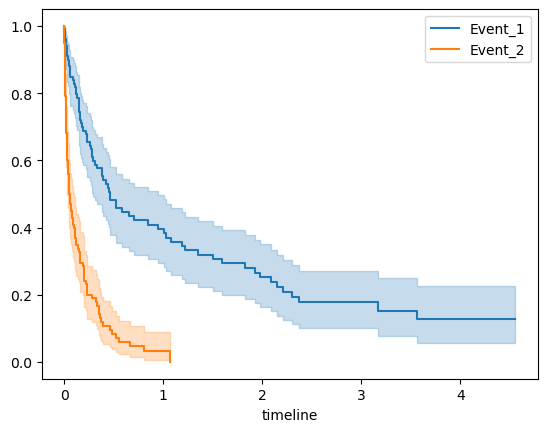

In [59]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import pandas as pd
from tabulate import tabulate

np.random.seed(1234)
n, p, k, rho = 100, 10, 2, 0.5
beta = np.zeros(p)
beta[np.linspace(0, p - 1, k, dtype=int)] = [1 for _ in range(k)]
Sigma = np.power(rho, np.abs(np.linspace(1, p, p) - np.linspace(1, p, p).reshape(p, 1)))
x = np.random.multivariate_normal(mean=np.zeros(p), cov=Sigma, size=(n,))
lambda1 = 1*np.exp(np.matmul(x, beta))
lambda2 = 10*np.exp(np.matmul(x, beta))

y, delta = make_Clayton2_data(n, theta=50, lambda1=lambda1, lambda2=lambda2, c1=5, c2=5)


kmf = KaplanMeierFitter()
for i in range(0, 2):
    event_name = 'Event_' + str(i+1)
    kmf.fit(y[:,i], delta[:,i], label=event_name, alpha=0.05)
    kmf.plot()

results = logrank_test(y[:,0], y[:,1], delta[:,0], delta[:,1])
key = ['t_0', 'null_distribution', 'degrees_of_freedom', 'test_name']
print('\n',tabulate(pd.DataFrame({'keys': key, 'value': [eval("results." + k) for k in key]}),showindex=False))
print('\n',tabulate(results.summary,showindex=False, headers=results.summary.columns))

The two survival curves do not cross, and the p value of log rank test is much less than 0.05. The above results show that there is a significant difference between their survival times.

A python code for solving such model is as following: 

In [3]:
import jax.numpy as jnp
from skscope import ScopeSolver

def multivariate_failure_objective(params):
    Xbeta = jnp.matmul(x, params)
    logsum1 = jnp.zeros_like(Xbeta)
    logsum2 = jnp.zeros_like(Xbeta)
    for i in range(0,n):
        logsum1 = logsum1.at[i].set(jnp.log(jnp.dot(y[:,0] >= y[:,0][i], jnp.exp(Xbeta))))
        logsum2 = logsum2.at[i].set(jnp.log(jnp.dot(y[:,1] >= y[:,1][i], jnp.exp(Xbeta))))
    return (jnp.dot(delta[:,0],logsum1)+jnp.dot(delta[:,1],logsum2)-jnp.dot(delta[:,0], Xbeta)-jnp.dot(delta[:,1], Xbeta))/n


solver = ScopeSolver(p, k)
solver.solve(multivariate_failure_objective, jit=True)

print("Estimated parameter:", solver.get_result()["params"], "objective:",solver.get_result()["objective_value"])
print("True parameter:", beta, "objective:",multivariate_failure_objective(beta))

Estimated parameter: [1.02098162 0.         0.         0.         0.         0.
 0.         0.         0.         0.97787917] objective: 5.544558048248291
True parameter: [1. 0. 0. 0. 0. 0. 0. 0. 0. 1.] objective: 5.545297


The algorithm has selected the correct variables, and the estimated coefficients and loss are very close to the true values.

### Reference

<div id="refer-1"></div>

- [1] Clegg L X, Cai J, Sen P K. A marginal mixed baseline hazards model for multivariate failure time data[J]. Biometrics, 1999, 55(3): 805-812.

<div id="refer-2"></div>

- [2] Jianwen Cai and others, Variable selection for multivariate failure time data, Biometrika, Volume 92, Issue 2, June 2005, Pages 303–316